In [1]:
import pandas as pd
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import sklearn as sk
from sklearn.linear_model import LinearRegression
import warnings
from pandas.errors import SettingWithCopyWarning

pro_df = pd.read_csv('progresa_sample.csv')

In [2]:
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
#converst poor column to binary
pro_df['poor'].replace('pobre'   , 1, inplace=True)
pro_df['poor'].replace('no pobre', 0, inplace=True)

pd.to_numeric(pro_df['poor'])

pro_df['progresa'].replace('basal', 1, inplace=True)
pro_df['progresa'].replace('0'    , 0, inplace=True)

pd.to_numeric(pro_df['progresa'])

variables = ['sex', 'indig', 'dist_sec','sc', 
             'grc', 'fam_n', 'min_dist', 'dist_cap', 
             'poor','progresa', 'hohedu', 'hohwag', 
             'welfare_index', 'hohsex', 'hohage', 'age', 
             'grc97','sc97']

options = ['count','mean', '50%', 'std']

variables.sort()

summary_stats = pro_df[variables].describe().transpose()

summary_stats[options]

,count,mean,50%,std
age,77250.0,11.366460,11.000000,3.167744
dist_cap,77250.0,147.674452,132.001494,76.063134
dist_sec,77250.0,2.418910,2.279000,2.234109
fam_n,77250.0,7.215715,7.000000,2.352900
grc,70701.0,3.963537,4.000000,2.499063
grc97,77250.0,3.705372,4.000000,2.572387
hohage,77240.0,44.436717,43.000000,11.620372
hohedu,77250.0,2.768104,2.000000,2.656106
hohsex,77230.0,0.925185,1.000000,0.263095
hohwag,77250.0,586.985312,500.000000,788.133664


In [4]:
t_and_c_pre_poor  = pro_df[(pro_df.year == 97) & (pro_df.poor == 1)]
t_and_c_post_poor = pro_df[(pro_df.year == 98) & (pro_df.poor == 1)]

#pre- and post-treatment df slices for treatment group (poor)
t_pre_poor  = pro_df[(pro_df.progresa == 1) & (pro_df.year == 97) & (pro_df.poor == 1)]
t_post_poor = pro_df[(pro_df.progresa == 1) & (pro_df.year == 98) & (pro_df.poor == 1)]

#pre- and post-treatment df slices for control group (poor)
c_pre_poor  = pro_df[(pro_df.progresa == 0) & (pro_df.year == 97) & (pro_df.poor == 1)]
c_post_poor = pro_df[(pro_df.progresa == 0) & (pro_df.year == 98) & (pro_df.poor == 1)]

#pre- and post-treatment df slices for treatment group, grouped by village (poor)
t_pre_poor_village  = t_pre_poor.groupby(['village'])
t_post_poor_village = t_post_poor.groupby(['village'])

#pre- and post-treatment df slices for control group, grouped by village (poor)
c_pre_poor_village  = c_pre_poor.groupby(['village'])
c_post_poor_village = c_post_poor.groupby(['village'])

In [5]:
#populates dictionary (key=variable) with average value for treatment, control, and differences
#also p-value

var_dict = {
    'male'       : [],
    'female'     : [],
    'indig'      : [],
    'non_indig'  : [],
    'dist_sec'   : [],
    'fam_n'      : [],
    'min_dist'   : [],
    'dist_cap'   : [],
    'hohedu'     : [],
    'hohwag'     : [],
    'hoh_male'   : [],
    'hoh_female' : [],
    'hohage'     : [],
    'age'        : []
}

test    = pro_df[(pro_df.year == 97) & (pro_df.progresa == 1) & (pro_df.poor == 1)]
control = pro_df[(pro_df.year == 97) & (pro_df.progresa == 0) & (pro_df.poor == 1)]

for key in var_dict:
    
    if key == 'male':
        var_dict[key].append(test.sex.mean())
        var_dict[key].append(control.sex.mean())
        var_dict[key].append(test.sex.mean()-control.sex.mean())
        var_dict[key].append(scipy.stats.ttest_ind(test.sex, control.sex, 
                                                   nan_policy='omit').pvalue)
        
    elif key == 'female':
        var_dict[key].append(1-test.sex.mean())
        var_dict[key].append(1-control.sex.mean())
        var_dict[key].append((1-test.sex.mean())-(1-control.sex.mean()))
        var_dict[key].append(scipy.stats.ttest_ind(test.sex, control.sex, 
                                                   nan_policy='omit').pvalue)
        
    elif key == 'non_indig':
        var_dict[key].append(1-test.indig.mean())
        var_dict[key].append(1-control.indig.mean())
        var_dict[key].append((1-test.indig.mean())-(1-control.indig.mean()))
        var_dict[key].append(scipy.stats.ttest_ind(test.indig, control.indig,
                                                  nan_policy='omit').pvalue)
        
    elif key == 'hoh_male':
        var_dict[key].append(test.hohsex.mean())
        var_dict[key].append(control.hohsex.mean())
        var_dict[key].append(test.hohsex.mean()-control.hohsex.mean())
        var_dict[key].append(scipy.stats.ttest_ind(test.hohsex, control.hohsex,
                                                  nan_policy='omit').pvalue)
        
    elif key == 'hoh_female':
        var_dict[key].append(1-test.hohsex.mean())
        var_dict[key].append(1-control.hohsex.mean())
        var_dict[key].append((1-test.hohsex.mean())-(1-control.hohsex.mean()))
        var_dict[key].append(scipy.stats.ttest_ind(test.hohsex, control.hohsex,
                                                   nan_policy='omit').pvalue)
        
    else:
        var_dict[key].append(test[key].mean())
        var_dict[key].append(control[key].mean())
        var_dict[key].append(test[key].mean()-control[key].mean())
        var_dict[key].append(scipy.stats.ttest_ind(test[key], control[key],
                                                  nan_policy='omit').pvalue)


In [6]:
#creates table to display dictionary from previous cell

col = ['Average value (Treatment villages)',
       'Average value (Control villages)',
       'Difference (Treat - Control)',
       'p-value']

var_df = pd.DataFrame.from_dict(var_dict, orient='index', columns = col )

var_df.index.name = 'Variable Name'
var_df = var_df.sort_index(axis='index', ascending=True)
var_df = var_df.style.set_properties(**{'text-align': 'right'})

var_df

,Average value (Treatment villages),Average value (Control villages),Difference (Treat - Control),p-value
Variable Name,,,,
age,10.716991,10.742023,-0.025032,0.478559
dist_cap,150.829074,153.769730,-2.940656,0.000842
dist_sec,2.453122,2.507662,-0.054540,0.035698
fam_n,7.281327,7.302469,-0.021142,0.427104
female,0.480683,0.494948,-0.014265,0.012192
hoh_female,0.075344,0.077053,-0.001709,0.571186
hoh_male,0.924656,0.922947,0.001709,0.571186
hohage,43.648828,44.276918,-0.628090,0.000002
hohedu,2.663139,2.590348,0.072791,0.011051


In [7]:
print(f"p-value: {scipy.stats.ttest_ind(t_pre_poor.sc, t_post_poor.sc,  nan_policy='omit').pvalue:.3}")

p-value: 1.3e-09


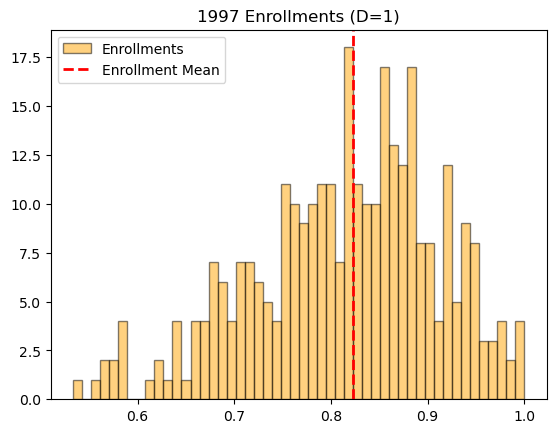

In [8]:
t_pre_hist = plt.hist(t_pre_poor_village.sc.mean(), 
                      label='Enrollments', 
                      bins=50, 
                      color='orange', 
                      edgecolor='black', 
                      alpha=.50
                     )

plt.axvline(t_pre_poor.sc.mean(), 
            color='red', 
            linestyle='--', 
            label='Enrollment Mean', 
            lw=2
           )

plt.title('1997 Enrollments (D=1)')

plt.legend()
plt.show()

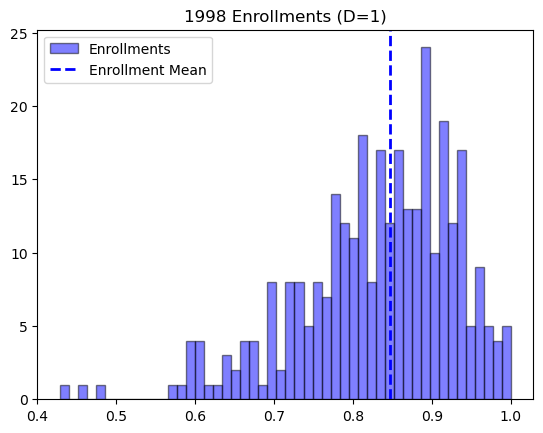

In [9]:
t_pre_hist = plt.hist(t_post_poor_village.sc.mean(), 
                      label='Enrollments', 
                      bins=50, 
                      color='blue', 
                      edgecolor='black', 
                      alpha=.50
                     )

plt.axvline(t_post_poor.sc.mean(), 
            color='blue', 
            linestyle='--', 
            label='Enrollment Mean', 
            lw=2)

plt.title('1998 Enrollments (D=1)')

plt.legend()
plt.show()

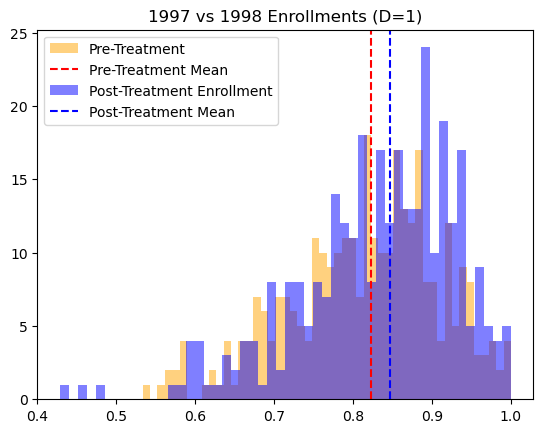

In [10]:
t_pre_hist = plt.hist(t_pre_poor_village.sc.mean(), 
                      label='Pre-Treatment', 
                      bins=50, 
                      color='orange', 
                      alpha =.5
                     )

plt.axvline(t_pre_poor.sc.mean(), 
            color='red', 
            linestyle='--', 
            label='Pre-Treatment Mean')

t_pre_hist = plt.hist(t_post_poor_village.sc.mean(), 
                      label='Post-Treatment Enrollment', 
                      bins=50, 
                      color='blue', 
                      alpha=.5
                     )

plt.axvline(t_post_poor.sc.mean(), 
            color='blue', 
            linestyle='--', 
            label='Post-Treatment Mean')

plt.title('1997 vs 1998 Enrollments (D=1)')

plt.legend()
plt.show()

In [11]:
t_enrollment_pvalue = scipy.stats.ttest_ind(t_pre_poor.sc, 
                                            t_post_poor.sc, 
                                            nan_policy='omit').pvalue

treatment_enrollment = pd.DataFrame({
    'Year' : [1997, 1998],
    
    'Average Enrollment Rate' : [t_pre_poor.sc.mean(), t_post_poor.sc.mean()],
    
    'Total Enrolled': [len(t_pre_poor[(t_pre_poor['sc'] == 1)]), 
                       len(t_post_poor[(t_post_poor['sc'] == 1)])
                      ],
    
    'Total Not Enrolled': [len(t_pre_poor[(t_pre_poor['sc'] == 0)]),
                           len(t_post_poor[(t_post_poor['sc'] == 0)])
                          ],
    
    'Missing Observations' : [(len(t_pre_poor.sc) - t_pre_poor.sc.count()),
                              (len(t_post_poor.sc) - t_post_poor.sc.count())
                             ],
    
    }).style.set_properties(**{'text-align': 'center'}).set_caption('(D=1)')


treatment_enrollment

,Year,Average Enrollment Rate,Total Enrolled,Total Not Enrolled,Missing Observations
0,1997,0.822697,15753,3395,1074
1,1998,0.846479,14413,2614,3195


In [12]:
t_pre_v_post_poor_ttest = scipy.stats.ttest_ind(t_pre_poor.sc, 
                                           t_post_poor.sc, 
                                           nan_policy='omit'
                                          )

print(f"Treatment Pre- vs. Post- Enrollment p-value:\n{t_pre_v_post_poor_ttest.pvalue:.3%}")

Treatment Pre- vs. Post- Enrollment p-value:
0.000%


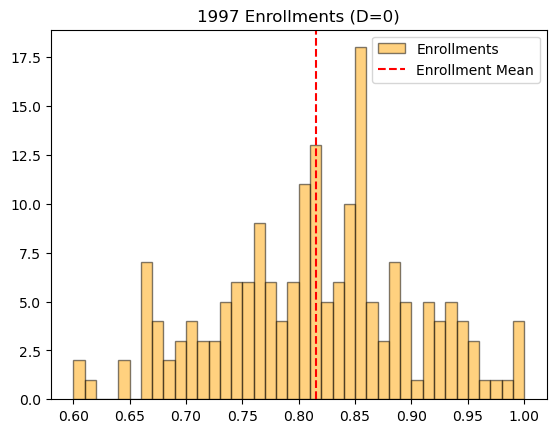

In [13]:
t_pre_hist = plt.hist(c_pre_poor_village.sc.mean(), 
                      label='Enrollments', 
                      bins=40, 
                      alpha=.5, 
                      edgecolor='black', 
                      color='orange'
                     )

plt.axvline(c_pre_poor.sc.mean(), 
            color='red', 
            linestyle='--', 
            label='Enrollment Mean'
           )

plt.title('1997 Enrollments (D=0)')

plt.legend()
plt.show()

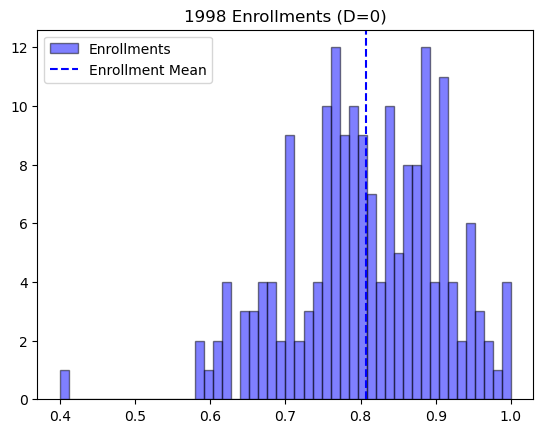

In [14]:
t_post_hist = plt.hist(c_post_poor_village.sc.mean(), 
                       label='Enrollments', 
                       bins=50, color='blue', 
                       edgecolor='black', 
                       alpha=.5)

plt.axvline(c_post_poor.sc.mean(), 
            color='blue', 
            linestyle='--', 
            label='Enrollment Mean')

plt.title('1998 Enrollments (D=0)')

plt.legend()
plt.show()

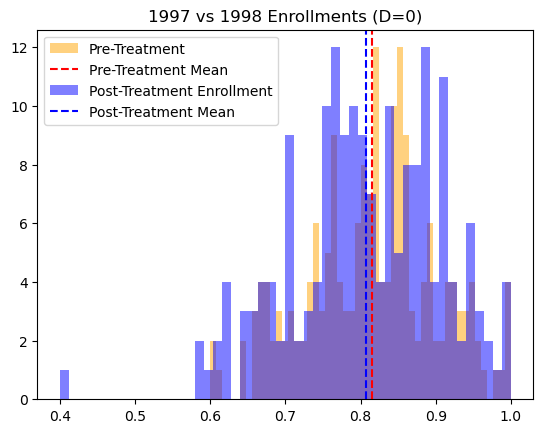

In [15]:
c_pre_hist = plt.hist(c_pre_poor_village.sc.mean(), 
                      label='Pre-Treatment', 
                      bins=50, 
                      color='orange', 
                      alpha =.5
                     )

plt.axvline(c_pre_poor.sc.mean(), 
            color='red', 
            linestyle='--', 
            label='Pre-Treatment Mean')

c_pre_hist = plt.hist(c_post_poor_village.sc.mean(), 
                      label='Post-Treatment Enrollment', 
                      bins=50, 
                      color='blue', 
                      alpha=.5
                     )

plt.axvline(c_post_poor.sc.mean(), 
            color='blue', 
            linestyle='--', 
            label='Post-Treatment Mean')

plt.title('1997 vs 1998 Enrollments (D=0)')

plt.legend()
plt.show()

In [16]:
control_enrollment = pd.DataFrame({
    'Year' : [1997, 1998],
    
    'Average Enrollment Rate' : [c_pre_poor.sc.mean(), c_post_poor.sc.mean()],
    
    'Total Enrolled': [len(c_pre_poor[(c_pre_poor['sc']   == 1)]), 
                       len(c_post_poor[(c_post_poor['sc'] == 1)])
                      ],
    
    'Total Not Enrolled': [len(c_pre_poor[(c_pre_poor['sc']   == 0)]),
                           len(c_post_poor[(c_post_poor['sc'] == 0)])
                          ],
    
    'Missing Observations' : [(len(c_pre_poor.sc)  - c_pre_poor.sc.count()),
                              (len(c_post_poor.sc) - c_post_poor.sc.count())
                             ],
    
    }).style.set_properties(**{'text-align': 'center'}).set_caption('(D=0)')


control_enrollment

,Year,Average Enrollment Rate,Total Enrolled,Total Not Enrolled,Missing Observations
0,1997,0.815186,9598,2176,700
1,1998,0.807637,8418,2005,2051


In [17]:
c_pre_v_post_poor_ttest = scipy.stats.ttest_ind(c_pre_poor.sc, 
                                                c_post_poor.sc, 
                                                nan_policy='omit'
                                               )

print(f"Control Pre- vs. Post- Enrollment p-value:\n{c_pre_v_post_poor_ttest.pvalue:.3%}")

Control Pre- vs. Post- Enrollment p-value:
15.113%


In [18]:
t_v_c_enrollment_poor = t_post_poor.sc.mean() - c_post_poor.sc.mean()

print(f"Average enrollments [Y_1|D=1]:           {t_post_poor.sc.mean()*100:.2f}%")
print(f"Average enrollments [Y_1|D=0]:           {c_post_poor.sc.mean()*100:.2f}%")
print(f"Average enrollments [Y_1|D=1]-[Y_1|D=0]: {t_v_c_enrollment_poor*100:.2f}%")

t_v_c_enrollment_poor_ttest = scipy.stats.ttest_ind(c_post_poor.sc, 
                                                    t_post_poor.sc, 
                                                    nan_policy='omit').pvalue

print(f"\nTreatment vs. Control Post- Enrollment p-value:\n{t_v_c_enrollment_poor_ttest:.4f}")

Average enrollments [Y_1|D=1]:           84.65%
Average enrollments [Y_1|D=0]:           80.76%
Average enrollments [Y_1|D=1]-[Y_1|D=0]: 3.88%

Treatment vs. Control Post- Enrollment p-value:
0.0000


In [19]:
X = t_and_c_post_poor.progresa
Y = t_and_c_post_poor.sc

model = ols('sc ~ progresa', 
            data=t_and_c_post_poor
           ).fit()

print("Treatment and Control Post-Treatment Simple Regression (Enrollment)\n")
print(model.summary())

Treatment and Control Post-Treatment Simple Regression (Enrollment)

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     69.87
Date:                Wed, 07 Feb 2024   Prob (F-statistic):           6.64e-17
Time:                        14:05:47   Log-Likelihood:                -11926.
No. Observations:               27450   AIC:                         2.386e+04
Df Residuals:                   27448   BIC:                         2.387e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

In [20]:
variables = 'progresa +\
            sex + indig +\
            dist_sec + fam_n +\
            min_dist + dist_cap +\
            hohedu + hohwag +\
            welfare_index + hohsex +\
            hohage + age'

model = ols(formula="sc ~ " + variables, 
            data=t_and_c_post_poor
           ).fit()

print("Treatment and Control Post-Treatment Multiple Regression (Enrollment)\n")
print(model.summary())

Treatment and Control Post-Treatment Multiple Regression (Enrollment)

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     784.0
Date:                Wed, 07 Feb 2024   Prob (F-statistic):               0.00
Time:                        14:05:47   Log-Likelihood:                -7539.2
No. Observations:               27260   AIC:                         1.511e+04
Df Residuals:                   27246   BIC:                         1.522e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

In [21]:
variables_min_progresa = 'sex +\
            indig + dist_sec +\
            fam_n + min_dist +\
            dist_cap + hohedu +\
            hohwag + welfare_index +\
            hohsex + hohage + age'

t_and_c_post_poor_s_ols = ols(formula = "sc ~ " + variables_min_progresa,
                            data = t_and_c_post_poor
                           ).fit()

print(t_and_c_post_poor_s_ols.summary())

model = t_and_c_post_poor_s_ols

intercept     = model.params.iloc[0]
sex           = model.params.iloc[1]
indig         = model.params.iloc[2]
dist_sec      = model.params.iloc[3]
fam_n         = model.params.iloc[4]
min_dist      = model.params.iloc[5]
dist_cap      = model.params.iloc[6]
hohedu        = model.params.iloc[7]
hohwag        = model.params.iloc[8]
welfare_index = model.params.iloc[9]
hohsex        = model.params.iloc[10]
hohage        = model.params.iloc[11]
age           = model.params.iloc[12]

tc_df = t_and_c_post_poor

tc_df['estimate'] =  (intercept                                 +
                       (tc_df['sex']           * sex)           +
                       (tc_df['indig']         * indig)         +
                       (tc_df['dist_sec']      * dist_sec)      +
                       (tc_df['fam_n']         * fam_n)         +
                       (tc_df['min_dist']      * min_dist)      +
                       (tc_df['dist_cap']      * dist_cap)      +
                       (tc_df['hohedu']        * hohedu)        +
                       (tc_df['hohwag']        * hohwag)        +
                       (tc_df['welfare_index'] * welfare_index) +
                       (tc_df['hohsex']        * hohsex)        +
                       (tc_df['hohage']        * hohage)        +
                       (tc_df['age']           * age)
                     )

t_and_c_post_poor['sc_sub_sc_est'] = (t_and_c_post_poor['sc']-t_and_c_post_poor['estimate'])

p_value = scipy.stats.ttest_ind(t_and_c_post_poor.progresa, 
                                t_and_c_post_poor.sc_sub_sc_est, 
                                nan_policy='omit'
                               ).pvalue

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     841.3
Date:                Wed, 07 Feb 2024   Prob (F-statistic):               0.00
Time:                        14:05:47   Log-Likelihood:                -7574.5
No. Observations:               27260   AIC:                         1.518e+04
Df Residuals:                   27247   BIC:                         1.528e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.4582      0.019     77.440

In [22]:
t_and_c_post_poor_estimate_s_ols = ols(formula = "sc_sub_sc_est ~ progresa", 
                                       data = t_and_c_post_poor
                                      ).fit()

print(t_and_c_post_poor_estimate_s_ols.summary())

                            OLS Regression Results                            
Dep. Variable:          sc_sub_sc_est   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     70.18
Date:                Wed, 07 Feb 2024   Prob (F-statistic):           5.67e-17
Time:                        14:05:47   Log-Likelihood:                -7539.5
No. Observations:               27260   AIC:                         1.508e+04
Df Residuals:                   27258   BIC:                         1.510e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0207      0.003     -6.604      0.0

In [23]:
# Your code here
pre_enrollment_d1  = t_pre_poor.sc.mean()
post_enrollment_d1 = t_post_poor.sc.mean()

pre_enrollment_d0  = c_pre_poor.sc.mean()
post_enrollment_d0 = c_post_poor.sc.mean()

d1_change = post_enrollment_d1 - pre_enrollment_d1
d0_change = post_enrollment_d0 - pre_enrollment_d0

treatment_impact = d1_change - d0_change

DD_table = pd.DataFrame({
    'Control' : [pre_enrollment_d0, post_enrollment_d0],
    'Treatment' : [pre_enrollment_d1, post_enrollment_d1]
})

DD_table.index=['1997','1998']
DD_table.index.name='year'

print(f"DD Estimate: {treatment_impact:.3%}")

DD_table.transpose()

DD Estimate: 3.133%


year,1997,1998
Control,0.815186,0.807637
Treatment,0.822697,0.846479


In [24]:
# Your code here
pd.options.mode.chained_assignment = None

control_variables = 'sex +\
            indig + dist_sec +\
            fam_n + min_dist +\
            dist_cap + hohedu +\
            hohwag + welfare_index +\
            hohsex + hohage + age'

pre_treatment_simple_ols = ols(formula = "sc ~ progresa", 
                               data = t_and_c_pre_poor
                              ).fit()

post_treatment_simple_ols = ols(formula = "sc ~ progresa", 
                                data = t_and_c_post_poor
                               ).fit()

pre_treatment_multi_ols = ols(formula = "sc ~ progresa +" + control_variables, 
                              data = t_and_c_pre_poor
                             ).fit() 

post_treatment_multi_ols = ols(formula = "sc ~ progresa +" + control_variables, 
                              data = t_and_c_post_poor
                              ).fit() 

pre_treatment = t_and_c_pre_poor
post_treatment = t_and_c_post_poor

#pre-treatment coefficients for simple regression
pre_t_simple_intercept = pre_treatment_simple_ols.params.iloc[0]
pre_t_simple_progresa  = pre_treatment_simple_ols.params.iloc[1]

#post-treatment coefficients for simple regression
post_t_simple_intercept = post_treatment_simple_ols.params.iloc[0]
post_t_simple_progresa  = post_treatment_simple_ols.params.iloc[1]

#pre-treatment coefficients for multi regression
pre_t_multi_intercept   = pre_treatment_multi_ols.params.iloc[0]
pre_t_multi_progresa    = pre_treatment_multi_ols.params.iloc[1]
pre_t_multi_sex         = pre_treatment_multi_ols.params.iloc[2]
pre_t_multi_indig       = pre_treatment_multi_ols.params.iloc[3]
pre_t_multi_distsec     = pre_treatment_multi_ols.params.iloc[4]
pre_t_multi_famn        = pre_treatment_multi_ols.params.iloc[5]
pre_t_multi_mindist     = pre_treatment_multi_ols.params.iloc[6]
pre_t_multi_distcap     = pre_treatment_multi_ols.params.iloc[7]
pre_t_multi_hohedu      = pre_treatment_multi_ols.params.iloc[8]
pre_t_multi_hohwag      = pre_treatment_multi_ols.params.iloc[9]
pre_t_multi_index       = pre_treatment_multi_ols.params.iloc[10]
pre_t_multi_hohsex      = pre_treatment_multi_ols.params.iloc[11]
pre_t_multi_hohage      = pre_treatment_multi_ols.params.iloc[12]
pre_t_multi_age         = pre_treatment_multi_ols.params.iloc[13]

#post-treatment coefficients for multi regression
post_t_multi_intercept  = post_treatment_multi_ols.params.iloc[0]
post_t_multi_progresa   = post_treatment_multi_ols.params.iloc[1]
post_t_multi_sex        = post_treatment_multi_ols.params.iloc[2]
post_t_multi_indig      = post_treatment_multi_ols.params.iloc[3]
post_t_multi_distsec    = post_treatment_multi_ols.params.iloc[4]
post_t_multi_famn       = post_treatment_multi_ols.params.iloc[5]
post_t_multi_mindist    = post_treatment_multi_ols.params.iloc[6]
post_t_multi_distcap    = post_treatment_multi_ols.params.iloc[7]
post_t_multi_hohedu     = post_treatment_multi_ols.params.iloc[8]
post_t_multi_hohwag     = post_treatment_multi_ols.params.iloc[9]
post_t_multi_index      = post_treatment_multi_ols.params.iloc[10]
post_t_multi_hohsex     = post_treatment_multi_ols.params.iloc[11]
post_t_multi_hohage     = post_treatment_multi_ols.params.iloc[12]
post_t_multi_age        = post_treatment_multi_ols.params.iloc[13]

pre_treatment['simple_ols_est']  = (pre_t_simple_intercept +
                                   (pre_treatment['progresa'] * pre_t_simple_progresa)
                                   )

post_treatment['simple_ols_est'] = (post_t_simple_intercept +
                                   (post_treatment['progresa'] * post_t_simple_progresa)
                                   )

pre_treatment['multi_ols_est']   = (pre_t_multi_intercept                                  +
                                   (pre_treatment['progresa']      * pre_t_multi_progresa) +
                                   (pre_treatment['sex']           * pre_t_multi_sex)      +
                                   (pre_treatment['indig']         * pre_t_multi_indig)    +
                                   (pre_treatment['dist_sec']      * pre_t_multi_distsec)  +
                                   (pre_treatment['fam_n']         * pre_t_multi_famn)     +
                                   (pre_treatment['min_dist']      * pre_t_multi_mindist)  +
                                   (pre_treatment['dist_cap']      * pre_t_multi_distcap)  +
                                   (pre_treatment['hohedu']        * pre_t_multi_hohedu)   + 
                                   (pre_treatment['hohwag']        * pre_t_multi_hohwag)   +
                                   (pre_treatment['welfare_index'] * pre_t_multi_index)    +
                                   (pre_treatment['hohsex']        * pre_t_multi_hohsex)   +
                                   (pre_treatment['hohage']        * pre_t_multi_hohage)   +
                                   (pre_treatment['age']           * pre_t_multi_age)
                                   )

post_treatment['multi_ols_est']   = (post_t_multi_intercept                                   +
                                    (post_treatment['progresa']      * post_t_multi_progresa) +
                                    (post_treatment['sex']           * post_t_multi_sex)      +
                                    (post_treatment['indig']         * post_t_multi_indig)    +
                                    (post_treatment['dist_sec']      * post_t_multi_distsec)  +
                                    (post_treatment['fam_n']         * post_t_multi_famn)     +
                                    (post_treatment['min_dist']      * post_t_multi_mindist)  +
                                    (post_treatment['dist_cap']      * post_t_multi_distcap)  +
                                    (post_treatment['hohedu']        * post_t_multi_hohedu)   + 
                                    (post_treatment['hohwag']        * post_t_multi_hohwag)   +
                                    (post_treatment['welfare_index'] * post_t_multi_index)    +
                                    (post_treatment['hohsex']        * post_t_multi_hohsex)   +
                                    (post_treatment['hohage']        * post_t_multi_hohage)   +
                                    (post_treatment['age']           * post_t_multi_age)
                                    )

#average estimated treatment effects for control group
Y0D0_simple_est_enrollment = pre_treatment[(pre_treatment['progresa'] == 0)].simple_ols_est.mean()
Y0D0_multi_est_enrollment  = pre_treatment[(pre_treatment['progresa'] == 0)].multi_ols_est.mean()
Y1D0_simple_est_enrollment = post_treatment[(post_treatment['progresa'] == 0)].simple_ols_est.mean()
Y1D0_multi_est_enrollment  = post_treatment[(post_treatment['progresa'] == 0)].multi_ols_est.mean()

#average estimated treatment effects for control group
Y0D1_simple_est_enrollment = pre_treatment[(pre_treatment['progresa'] == 1)].simple_ols_est.mean()
Y0D1_multi_est_enrollment  = pre_treatment[(pre_treatment['progresa'] == 1)].multi_ols_est.mean()
Y1D1_simple_est_enrollment = post_treatment[(post_treatment['progresa'] == 1)].simple_ols_est.mean()
Y1D1_multi_est_enrollment  = post_treatment[(post_treatment['progresa'] == 1)].multi_ols_est.mean()

In [25]:
#Average Estimated Treatment Effect (Simple Regression) Differences-in-Differences  

D0_simple_est_treatment_effect = Y1D0_simple_est_enrollment - Y0D0_simple_est_enrollment
D1_simple_est_treatment_effect = Y1D1_simple_est_enrollment - Y0D1_simple_est_enrollment

DD_treatment_effect = D1_simple_est_treatment_effect - D0_simple_est_treatment_effect

DD_table = pd.DataFrame({
    'Control'   : [Y0D0_simple_est_enrollment, Y1D0_simple_est_enrollment],
    'Treatment' : [Y0D1_simple_est_enrollment, Y1D1_simple_est_enrollment]
})


DD_table.index=['1997','1998']
DD_table.index.name='year'

print("Simple Regression\n")
print(DD_table.transpose())
print(f"\nDD Estimated Treatment Effect: {DD_treatment_effect:.3%}")

Simple Regression

year           1997      1998
Control    0.815186  0.807637
Treatment  0.822697  0.846479

DD Estimated Treatment Effect: 3.133%


In [26]:
#Average Estimated Treatment Effect (Multiple Regression) Differences-in-Differences  

D0_multi_est_treatment_effect = Y1D0_multi_est_enrollment - Y0D0_multi_est_enrollment
D1_multi_est_treatment_effect = Y1D1_multi_est_enrollment - Y0D1_multi_est_enrollment

DD_treatment_effect = D1_multi_est_treatment_effect - D0_multi_est_treatment_effect

DD_table = pd.DataFrame({
    'Control'   : [Y0D0_multi_est_enrollment, Y1D0_multi_est_enrollment],
    'Treatment' : [Y0D1_multi_est_enrollment, Y1D1_multi_est_enrollment]
})


DD_table.index=['1997','1998']
DD_table.index.name='year'

print("Multiple Regression\n")
print(DD_table.transpose())
print(f"\nDD Estimated Treatment Effect: {DD_treatment_effect:.3%}")

Multiple Regression

year           1997      1998
Control    0.816155  0.778005
Treatment  0.823279  0.815926

DD Estimated Treatment Effect: 3.080%


In [27]:
d1_pre_treatment = pro_df[(pro_df['progresa'] == 1) & (pro_df['year'] == 97) & (pro_df['poor'] == 0)]
d1_post_treatment = pro_df[(pro_df['progresa'] == 1) & (pro_df['year'] == 98) & (pro_df['poor'] == 0)]

d0_pre_treatment = pro_df[(pro_df['progresa'] == 0) & (pro_df['year'] == 97) & (pro_df['poor'] == 0)]
d0_post_treatment = pro_df[(pro_df['progresa'] == 0) & (pro_df['year'] == 98) & (pro_df['poor'] == 0)]

##-------------------------------------------------------##
#Progresa impacts on enrollments for non-poor

d1_pre_enrollment  = d1_pre_treatment.sc.mean()
d1_post_enrollment = d1_post_treatment.sc.mean()
d1_enrollment_impact = d1_post_enrollment - d1_pre_enrollment

d0_pre_enrollment = d0_pre_treatment.sc.mean()
d0_post_enrollment = d0_post_treatment.sc.mean()
d0_enrollment_impact = d0_post_enrollment - d0_pre_enrollment

enrollment_DD = d1_enrollment_impact - d0_enrollment_impact

##-------------------------------------------------------##
#progresa impacts on distance to nearest secondary school for non-poor

d1_pre_distsec = d1_pre_treatment.dist_sec.mean()
d1_post_distsec = d1_post_treatment.dist_sec.mean()
d1_distsec_impact = d1_post_distsec - d1_pre_distsec

d0_pre_distsec = d1_pre_treatment.dist_sec.mean()
d0_post_distsec = d0_post_treatment.dist_sec.mean()
d0_distsec_impact = d0_post_distsec - d0_pre_distsec

distsec_DD = d1_distsec_impact - d0_distsec_impact

##-------------------------------------------------------##
#progresa impacts on number of family members for non-poor

d1_pre_famn = d1_pre_treatment.fam_n.mean()
d1_post_famn = d1_post_treatment.fam_n.mean()
d1_famn_impact = d1_post_famn - d1_pre_famn

d0_pre_famn = d0_pre_treatment.fam_n.mean()
d0_post_famn = d0_post_treatment.fam_n.mean()
d0_famn_impact = d0_post_famn - d0_pre_famn

famn_DD = d1_famn_impact - d0_famn_impact

##-------------------------------------------------------##
#progresa impacts on distance to nearest urban center for non-poor

d1_pre_mindist = d1_pre_treatment.min_dist.mean()
d1_post_mindist = d1_post_treatment.min_dist.mean()
d1_mindist_impact = d1_post_mindist - d1_pre_mindist

d0_pre_mindist = d0_pre_treatment.min_dist.mean()
d0_post_mindist = d0_post_treatment.min_dist.mean()
d0_mindist_impact = d0_post_mindist - d0_pre_mindist

mindist_DD = d1_mindist_impact - d0_mindist_impact

##-------------------------------------------------------##
#progresa impacts on distance to capital for non-poor

d1_pre_distcap = d1_pre_treatment.dist_cap.mean()
d1_post_distcap = d1_post_treatment.dist_cap.mean()
d1_distcap_impact = d1_post_distcap - d1_pre_distcap

d0_pre_distcap = d0_pre_treatment.dist_cap.mean()
d0_post_distcap = d0_post_treatment.dist_cap.mean()
d0_distcap_impact = d0_post_distcap - d0_pre_distcap

distcap_DD = d1_distcap_impact - d0_distcap_impact
##-------------------------------------------------------##
#progresa impacts on head of household education for non-poor
d1_pre_hohedu = d1_pre_treatment.hohedu.mean()
d1_post_hohedu = d1_post_treatment.hohedu.mean()
d1_hohedu_impact = d1_post_hohedu - d1_pre_hohedu

d0_pre_hohedu = d0_pre_treatment.hohedu.mean()
d0_post_hohedu = d0_post_treatment.hohedu.mean()
d0_hohedu_impact = d0_post_hohedu - d0_pre_hohedu

hohedu_impact = d1_hohedu_impact - d0_hohedu_impact

##-------------------------------------------------------##
#progresa impacts on head of household wages for non-poor

d1_pre_hohwag = d1_pre_treatment.hohwag.mean()
d1_post_hohwag = d1_post_treatment.hohwag.mean()
d1_hohwag_impact = d1_post_hohwag - d1_pre_hohwag

d0_pre_hohwag = d0_pre_treatment.hohwag.mean()
d0_post_hohwag = d0_post_treatment.hohwag.mean()
d0_hohwag_impact = d0_post_hohwag - d0_pre_hohwag

hohwag_DD = d1_hohwag_impact - d0_hohwag_impact

##-------------------------------------------------------##
#progresa impacts on welfare index for non-poor

d1_pre_index = d1_pre_treatment.welfare_index.mean()
d1_post_index = d1_post_treatment.welfare_index.mean()
d1_index_impact =  d1_post_index - d1_pre_index 

d0_pre_index = d0_pre_treatment.welfare_index.mean()
d0_post_index = d0_post_treatment.welfare_index.mean()
d0_index_impact = d0_post_index - d0_pre_index

index_DD = d1_index_impact - d0_index_impact

##-------------------------------------------------------##

In [28]:
header = pd.MultiIndex.from_product([['control','treatment'],
                                     ['1997','1998','change']],
                                    )

table = pd.DataFrame(0, 
                     index=['Enrollment',
                               'dist_sec',
                               'fam_n',
                               'min_dist',
                               'dist_cap',
                               'hoh_edu',
                               'hoh_wag',
                               'welfare_index'], 
                     columns=header
                    )


table.loc['Enrollment', ('control', '1997')]        = d0_pre_enrollment
table.loc['Enrollment', ('control', '1998')]        = d0_post_enrollment
table.loc['Enrollment', ('control', 'change')]      = d0_enrollment_impact
table.loc['Enrollment', ('treatment', '1997')]      = d1_pre_enrollment
table.loc['Enrollment', ('treatment', '1998')]      = d1_post_enrollment
table.loc['Enrollment', ('treatment', 'change')]    = d1_enrollment_impact

table.loc['dist_sec', ('control', '1997')]          = d0_pre_distsec
table.loc['dist_sec', ('control', '1998')]          = d0_post_distsec
table.loc['dist_sec', ('control', 'change')]        = d0_distsec_impact
table.loc['dist_sec', ('treatment', '1997')]        = d1_pre_distsec
table.loc['dist_sec', ('treatment', '1998')]        = d1_post_distsec
table.loc['dist_sec', ('treatment', 'change')]      = d1_distsec_impact

table.loc['fam_n', ('control', '1997')]             = d0_pre_famn
table.loc['fam_n', ('control', '1998')]             = d0_post_famn
table.loc['fam_n', ('control', 'change')]           = d0_famn_impact
table.loc['fam_n', ('treatment', '1997')]           = d1_pre_famn
table.loc['fam_n', ('treatment', '1998')]           = d1_post_famn
table.loc['fam_n', ('treatment', 'change')]         = d1_famn_impact

table.loc['min_dist', ('control', '1997')]          = d0_pre_mindist
table.loc['min_dist', ('control', '1998')]          = d0_post_mindist
table.loc['min_dist', ('control', 'change')]        = d0_mindist_impact
table.loc['min_dist', ('treatment', '1997')]        = d1_pre_mindist
table.loc['min_dist', ('treatment', '1998')]        = d1_post_mindist
table.loc['min_dist', ('treatment', 'change')]      = d1_mindist_impact

table.loc['dist_cap', ('control', '1997')]          = d0_pre_distcap
table.loc['dist_cap', ('control', '1998')]          = d0_post_distcap
table.loc['dist_cap', ('control', 'change')]        = d0_distcap_impact
table.loc['dist_cap', ('treatment', '1997')]        = d1_pre_distcap
table.loc['dist_cap', ('treatment', '1998')]        = d1_post_distcap
table.loc['dist_cap', ('treatment', 'change')]      = d1_distcap_impact

table.loc['hoh_edu', ('control', '1997')]           = d0_pre_hohedu
table.loc['hoh_edu', ('control', '1998')]           = d0_post_hohedu
table.loc['hoh_edu', ('control', 'change')]         = d0_hohedu_impact
table.loc['hoh_edu', ('treatment', '1997')]         = d1_pre_hohedu
table.loc['hoh_edu', ('treatment', '1998')]         = d1_post_hohedu
table.loc['hoh_edu', ('treatment', 'change')]       = d1_hohedu_impact

table.loc['hoh_wag', ('control', '1997')]           = d0_pre_hohwag
table.loc['hoh_wag', ('control', '1998')]           = d0_post_hohwag
table.loc['hoh_wag', ('control', 'change')]         = d0_hohwag_impact
table.loc['hoh_wag', ('treatment', '1997')]         = d1_pre_hohwag
table.loc['hoh_wag', ('treatment', '1998')]         = d1_post_hohwag
table.loc['hoh_wag', ('treatment', 'change')]       = d1_hohwag_impact

table.loc['welfare_index', ('control', '1997')]     = d0_pre_index
table.loc['welfare_index', ('control', '1998')]     = d0_post_index
table.loc['welfare_index', ('control', 'change')]   = d0_index_impact
table.loc['welfare_index', ('treatment', '1997')]   = d1_pre_index
table.loc['welfare_index', ('treatment', '1998')]   = d1_post_index
table.loc['welfare_index', ('treatment', 'change')] = d1_index_impact

table

control                         treatment              \
                     1997        1998    change        1997        1998   
Enrollment       0.762587    0.776337  0.013750    0.795264    0.809049   
dist_sec         2.070875    2.182458  0.111584    2.070875    2.070875   
fam_n            6.888233    6.888233  0.000000    6.756886    6.756886   
min_dist        90.734247   90.734247  0.000000   91.594810   91.594810   
dist_cap       120.619666  120.619666  0.000000  126.404535  126.404535   
hoh_edu          3.396457    3.396457  0.000000    3.569140    3.569140   
hoh_wag        764.569992  764.569992  0.000000  759.481664  759.481664   
welfare_index  879.263159  879.263159  0.000000  871.340460  871.340460   

                         
                 change  
Enrollment     0.013785  
dist_sec       0.000000  
fam_n          0.000000  
min_dist       0.000000  
dist_cap       0.000000  
hoh_edu        0.000000  
hoh_wag        0.000000  
welfare_index  0.000000

In [34]:
2.0*2.1

4.2

In [29]:
table = pd.DataFrame({
    'Enrollment'    : [enrollment_DD],
    'dist_sec'      : [distsec_DD],
    'fam_n'         : [famn_DD],
    'min_dist'      : [mindist_DD],
    'dist_cap'      : [distcap_DD],
    'hoh_edu'       : [hohedu],
    'hoh_wag'       : [hohwag],
    'welfare_index' : [index_DD]
})


table.index=['Double Difference']
table.index.name='year'

table.transpose()

year,Double Difference
Enrollment,0.000034
dist_sec,-0.111584
fam_n,0.000000
min_dist,0.000000
dist_cap,0.000000
hoh_edu,0.007919
hoh_wag,-0.000002
welfare_index,0.000000
